In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

http://tillbergmann.com/blog/python-gradient-descent.html

$$ J(W)=\frac{1}{2m}(XW−Y)^T(XW−Y) $$

In [59]:
#Evaluate the linear regression
def compute_cost(X, Y, W):
    '''
    Compute cost for linear regression
    '''
    #Number of training samples
    m = Y.size
    E = X.dot(W) - Y
    J = (E.T).dot(E)/ (2. * m)
    return J

$$ W = W − \eta \frac{1}{m}(X^T(XW−Y)) $$

(442, 10)
(442,)
X.shape: (442,) float64
y.shape: (442,) float64


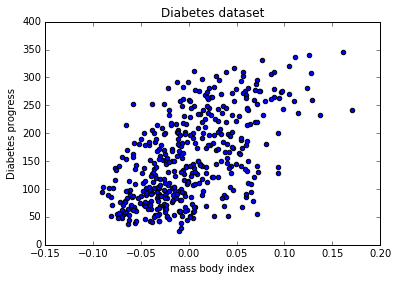

In [122]:
def gradient_descent(X, Y, eta, num_iters):
    '''
    Perform gradient descent to learn W
    by taking num_items gradient steps with learning
    rate eta
    '''
    m = Y.size
    W = np.zeros(shape=(2, 1))
    J_history = np.zeros(shape=(num_iters, ))
    W_history = np.zeros(shape=(2,num_iters))

    for i in range(num_iters):
        errors = (X.T).dot(X.dot(W) - Y)
        W = W - eta * (1.0 / m) * errors
    
        W_history[:,i] = W[:,0]
        J_history[i] = compute_cost(X, Y, W)
    return W, J_history, W_history


#Load the dataset
# Load the diabetes dataset
diabetes = datasets.load_diabetes()
print diabetes.data.shape
print diabetes.target.shape

X = diabetes.data[:, 2] # body mass index
y = diabetes.target

#X = X[:300]
#y = y[:300]

#y = 2 * X
print 'X.shape:', X.shape, X.dtype
print 'y.shape:', y.shape, y.dtype
#print X[:10],y[:10]

#Plot the data
plt.scatter(X, y, marker='o', c='b')
plt.title('Diabetes dataset')
plt.xlabel('mass body index')
plt.ylabel('Diabetes progress')
plt.show()

X_bias.shape: (442, 2)
final cost: [[ 1945.23146317]]


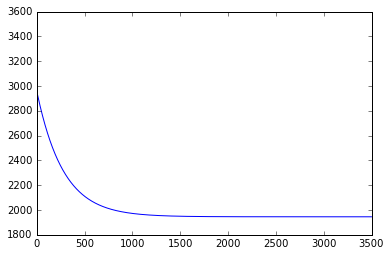

W_optimal: [[ 152.13348416]
 [ 947.76114332]]
For index mass = 0, we predict a diabetes increase of 152.133484
For index mass = 0.1, we predict a diabetes increase of 246.909598


In [108]:
#number of training samples
m = y.size

#Add a column of ones to X (interception data)
X_bias = np.hstack([np.ones(shape=(m, 1)), X.reshape(-1,1)])
print 'X_bias.shape:',X_bias.shape
Y_matrix = y.reshape(-1,1)


#Some gradient descent settings
iterations = 3500
eta = 0.8

W_optimal, J_history, W_history = gradient_descent(X_bias, Y_matrix, eta, iterations)

print 'final cost:', compute_cost(X_bias, Y_matrix, W_optimal)

plt.plot(J_history)
plt.show()

print 'W_optimal:', W_optimal
#Predict values for index bodies of 0 and 0.1
predict1 = np.array([1, 0.0]).dot(W_optimal).flatten()
print 'For index mass = 0, we predict a diabetes increase of %f' % (predict1)
predict2 = np.array([1, 0.1]).dot(W_optimal).flatten()
print 'For index mass = 0.1, we predict a diabetes increase of %f' % (predict2)

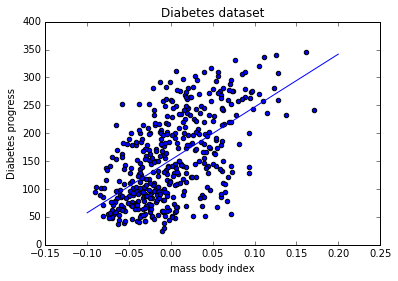

In [109]:
#Plot the results
#Plot the data
plt.scatter(X, y, marker='o', c='b')
plt.title('Diabetes dataset')
plt.xlabel('mass body index')
plt.ylabel('Diabetes progress')

x = np.arange(-0.1,0.2,0.1).reshape(-1,1)
x_bias = np.hstack([np.ones_like(x),x])
result = x_bias.dot(W_optimal).flatten()
plt.plot(x, result)
plt.show()

Wmin: [ 97.36542986   1.37474789]
Wmax: [  182.560181    1137.31337198]
(100, 100)
(2, 10000)
(442, 2)
J.shape: (10000,)
W_history.shape: (2, 3500)


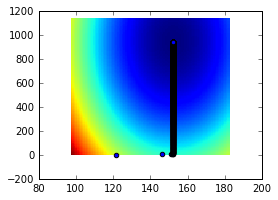

In [110]:

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Wmin = W_history.min(axis=1)
Wmax = W_history.max(axis=1)
D = Wmax - Wmin
Wmin *= 0.8
Wmax *= 1.2
print 'Wmin:', Wmin
print 'Wmax:', Wmax
xx, yy = np.meshgrid(np.linspace(Wmin[0], Wmax[0], 100), np.linspace(Wmin[1], Wmax[1], 100))
W_grid = np.c_[xx.ravel(), yy.ravel()].T
print xx.shape
print W_grid.shape
print X_bias.shape

m = Y_matrix.size

E = ((X_bias.dot(W_grid) - Y_matrix)**2).sum(axis=0)

J = E/(2. * m)
print 'J.shape:', J.shape
print 'W_history.shape:', W_history.shape

# Put the result into a color plot
J = J.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, J)#, cmap=plt.cm.Paired)

plt.scatter(W_history[0],W_history[1])
plt.show()



1.5.1


AttributeError: 'AxesSubplot' object has no attribute 'plot_wireframe'

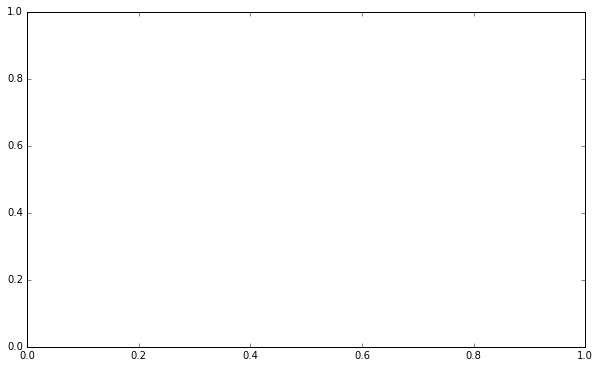

In [121]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
print matplotlib.__version__
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)#, projection='3d')
#ax = Axes3D(fig)

ax.plot_surface(xx, yy, J, rstride=1, cstride=1, color='b', alpha=0.5)
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Cost')
ax.view_init(elev=30., azim=30)
#ax.plot([theta[0]], [theta[1]], [cost[-1]] , markerfacecolor='r', markeredgecolor='r', marker='o', markersize=7);